In [11]:
import nltk
import nltk.corpus
from nltk.sentiment import SentimentAnalyzer

from dateutil.parser import parse

import pytz

from itertools import groupby

import matplotlib.pyplot as plt
import mpld3

import numpy as np

from random import randint

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD

import pandas as pd

from prepare_data import retrieve_data

%matplotlib inline

In [2]:
data = retrieve_data()
candidates = data.keys()

# Who talks about Whom?

In [3]:
stopwords = nltk.corpus.stopwords.words('english') + ["http", "URL", "https"]
words = [(candidate, w) for candidate in data
         for m in data[candidate]["messages"]
         for w in nltk.word_tokenize(m["body"]) 
         if w.isalpha() and w.lower() not in stopwords]

cfd = nltk.ConditionalFreqDist(words)

Count                                                    \
Mentioned      Bush    Carson  Christie   Clinton      Cruz   Fiorina   
Mentioner                                                               
Bush       0.103448  0.034483  0.103448  0.103448  0.086207  0.034483   
Carson     0.000000  4.833333  0.000000  0.000000  0.000000  0.000000   
Christie   0.000000  0.000000  2.225352  0.281690  0.000000  0.000000   
Clinton    0.000000  0.007407  0.007407  0.188889  0.037037  0.000000   
Cruz       0.016667  0.016667  0.000000  0.183333  6.591667  0.050000   
Fiorina    0.053571  0.017857  0.053571  0.392857  0.714286  0.232143   
Kasich     0.029412  0.000000  0.029412  0.666667  0.558824  0.009804   
Paul       0.000000  0.000000  0.000000  0.090909  0.000000  0.000000   
Rubio      0.000000  0.000000  0.008130  0.252033  0.040650  0.000000   
Sanders    0.010490  0.000000  0.000000  0.846154  0.003497  0.000000   
Santorum   0.000000  0.000000  0.000000  0.258065  0.032258  0.000000   
Trump      0.000000  0.000000  0.000000  0.317757  0.000000  0.000000   

                                                                       
Mentioned    Kasich      Paul     Rubio   Sanders  Santorum     Trump  
Mentioner                                                              
Bush       0.137931  0.000000  0.172414  0.000000  0.000000  0.068966  
Carson     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
Christie   0.000000  0.014085  0.028169  0.000000  0.000000  2.549296  
Clinton    0.029630  0.003704  0.007407  0.044444  0.000000  0.551852  
Cruz       0.066667  0.058333  0.158333  0.000000  0.008333  1.400000  
Fiorina    0.071429  0.017857  0.035714  0.000000  0.000000  0.392857  
Kasich     4.235294  0.019608  0.029412  0.019608  0.000000  0.666667  
Paul       0.000000  2.454545  0.000000  0.000000  0.000000  0.000000  
Rubio      0.000000  0.000000  1.975610  0.024390  0.000000  0.024390  
Sanders    0.003497  0.069930  0.000000  0.807692  0.000000  0.258741  
Santorum   0.000000  0.000000  1.032258  0.032258  1.129032  0.193548  
Trump      0.000000  0.018692  0.000000  0.000000  0.000000  4.046729

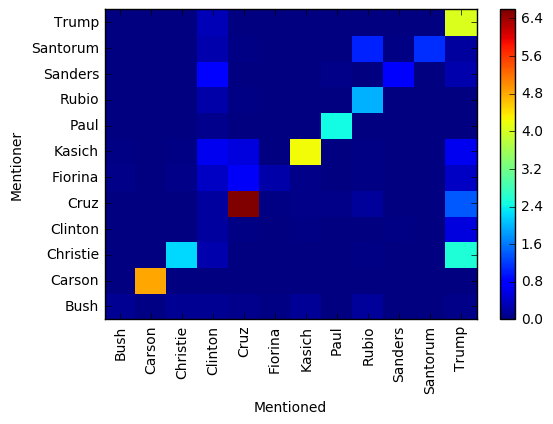

In [4]:
candidate_mentions = [(k, o, cfd[k][o] / float(len(data[k]["messages"]))) for k in cfd.keys() for o in candidates]

mentioner, mentioned, counts = list(zip(*candidate_mentions))
indices = pd.MultiIndex.from_tuples(list(zip(mentioner, mentioned)),names=['Mentioner', 'Mentioned'])
mention_matrix = pd.DataFrame({"Count": counts}, index=indices).unstack()
#plt.imshow(mention_matrix, cmap='hot', interpolation='nearest')
plt.pcolor(mention_matrix)
plt.yticks(np.arange(0.5, len(mention_matrix.index), 1), mention_matrix.index)
plt.xticks(np.arange(0.5, len(mention_matrix.columns), 1), mention_matrix.index,rotation=90)
plt.xlabel("Mentioned")
plt.ylabel("Mentioner")

plt.colorbar()
mention_matrix

# Dimensionality Reduction

In [5]:
def perform_svd(candidates, title):    
    bow = [dict(cfd[c].most_common(20)) for c in candidates]
    vec = DictVectorizer()
    mat = vec.fit_transform(bow).toarray()
    svd = TruncatedSVD(n_components=2, n_iter=12, random_state=42)
    svd.fit(mat)
    transformed = svd.fit_transform(mat)

    fig = plt.figure()

    colors = ["red" if data[k]["party"] == "Republicans" else "blue" for k in candidates]
    width = max(transformed[:,0])
    height = max(transformed[:,1])
    scatter = plt.scatter(transformed[:,0]/width, transformed[:,1]/height, label=candidates, c=colors, s=60)

    plt.title(title, size=20)
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(candidates))
    mpld3.plugins.connect(fig, tooltip)
    return mpld3.display()

In [6]:
perform_svd(candidates, "Candidates")

In [7]:
republicans = [c for c in list(candidates) if c not in ["Clinton", "Sanders"]]
perform_svd(republicans, "Republicans")

# Time Analysis

In [40]:
trump_emails = []
for m in data["Trump"]["messages"]:
    days = (np.datetime64(parse(m["date"][5:16])) - np.datetime64('2016-01-01')) / np.timedelta64(1, 'D')
    words = [w for w in nltk.word_tokenize(m["body"]) if w not in stopwords and w.isalpha()]
    fd = nltk.FreqDist(words).most_common(20)
    trump_emails.append((days, fd))

In [42]:
trump_emails[:5]

[(22.0,
  [('New', 4),
   ('Trump', 3),
   ('NH', 3),
   ('January', 3),
   ('Hampshire', 2),
   ('Monday', 2),
   ('Donald', 2),
   ('Nashua', 2),
   ('open', 2),
   ('available', 2),
   ('President', 2),
   ('events', 2),
   ('start', 1),
   ('John', 1),
   ('Details', 1),
   ('On', 1),
   ('Team', 1),
   ('York', 1),
   ('Tara', 1),
   ('NashuaDoors', 1)]),
 (23.0,
  [('New', 4),
   ('Trump', 3),
   ('NH', 3),
   ('January', 3),
   ('Hampshire', 2),
   ('Donald', 2),
   ('Nashua', 2),
   ('open', 2),
   ('available', 2),
   ('President', 2),
   ('events', 2),
   ('start', 1),
   ('emails', 1),
   ('Details', 1),
   ('Monday', 1),
   ('Team', 1),
   ('York', 1),
   ('Tara', 1),
   ('NashuaDoors', 1),
   ('Avenue', 1)]),
 (24.0,
  [('January', 7),
   ('Open', 5),
   ('Starts', 5),
   ('IA', 4),
   ('available', 4),
   ('week', 3),
   ('South', 2),
   ('City', 2),
   ('Trump', 2),
   ('NH', 2),
   ('join', 2),
   ('Iowa', 2),
   ('Marshalltown', 2),
   ('us', 2),
   ('emails', 1),
   (

# Word Clouds

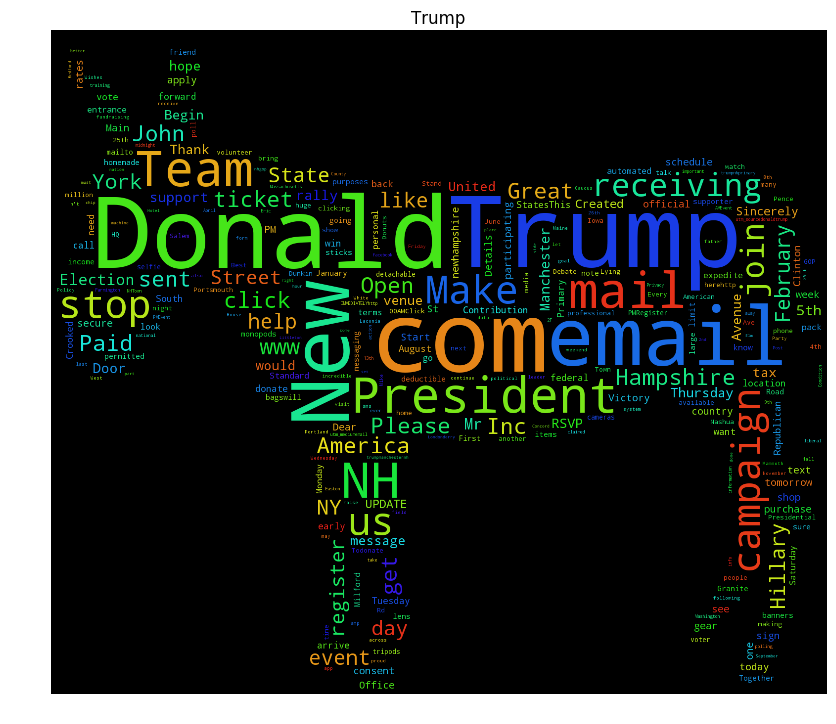

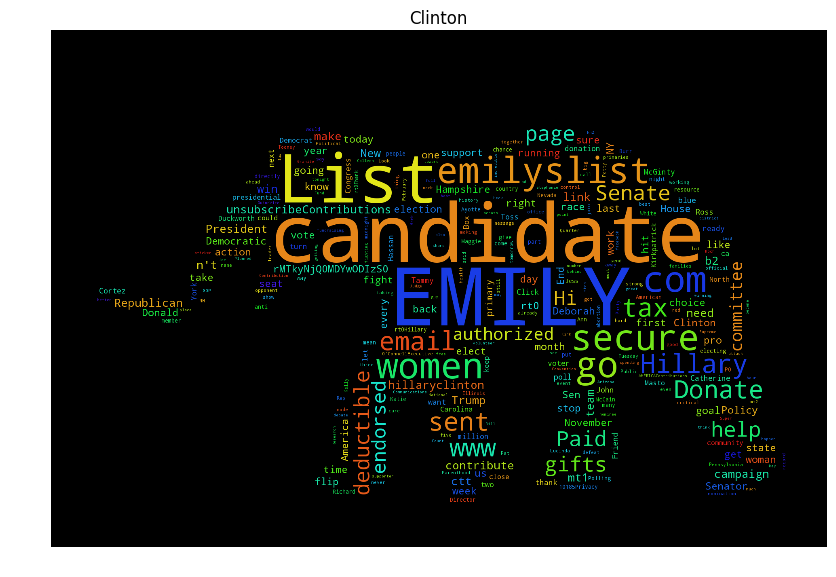

In [8]:
from PIL import Image
from os import path
import random
from wordcloud import WordCloud, STOPWORDS

useless_words = ["donaldjtrump", "eventbrite", "10022This", "98xjsmith", "org",\
                 "unsubscribe", "donaldtrump", "Inc725", "http", "https","nationbuilder", \
                 "gmail", "TrumpTEXT", "EXCLUSIVE", "EMILY's", "emilys" "emilyslist"]
stopwords = set(nltk.corpus.stopwords.words("english") + useless_words)


def show_wordCloud(img, candidate):
    mask = np.array(Image.open(img))

    text = " ".join([w for message in data[candidate]["messages"] \
                     for w in nltk.word_tokenize(message["body"]) if w not in stopwords])

    wc = WordCloud(max_words=300, mask=mask, stopwords=stopwords, margin=10,random_state=1).generate(text)
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title(candidate)
    plt.imshow(wc.to_array())
    plt.show()

show_wordCloud("wordcloud/donkey.jpg", "Trump")
show_wordCloud("wordcloud/elephant.jpg", "Clinton")

The wordclouds above show that there is not too much diversity between the candidates' word choice, other than Hillary talking about women and Trump talking about corporations. Based solely on the Hillary wordcloud, it seems that Hillary is determined to convince people that her email server was "secure" and that she was "authorized" to use it. It also looks like Trump talked about Hillary more than Hillary talked about Trump.